# unit 2.1

In [ ]:
from litellm import max_tokens
from smolagents import CodeAgent, InferenceClientModel, tool
from sympy.physics.units import temperature

from langchain.langchain_practice import similarity


# Let's pretend we have a function that fetches the highest-rated catering services.
@tool
def catering_service_tool(query: str) -> str:
    """
    This tool returns the highest-rated catering service in Gotham City.

    Args:
        query: A search term for finding catering services.
    """
    # Example list of catering services and their ratings
    services = {
        "Gotham Catering Co.": 4.9,
        "Wayne Manor Catering": 4.8,
        "Gotham City Events": 4.7,
    }

    # Find the highest rated catering service (simulating search query filtering)
    best_service = max(services, key=services.get)

    return best_service


agent = CodeAgent(tools=[catering_service_tool], model=InferenceClientModel())

# Run the agent to find the best catering service
result = agent.run(
    "Can you give me the name of the highest-rated catering service in Gotham City?"
)

print(result)  # Output: Gotham Catering Co.

In [ ]:
from smolagents import Tool, CodeAgent, InferenceClientModel


class SuperheroPartyThemeTool(Tool):
    name = "superhero_party_theme_generator"
    description = """
    This tool suggests creative superhero-themed party ideas based on a category.
    It returns a unique party theme idea."""

    inputs = {
        "category": {
            "type": "string",
            "description": "The type of superhero party (e.g., 'classic heroes', 'villain masquerade', 'futuristic Gotham').",
        }
    }

    output_type = "string"

    def forward(self, category: str):
        themes = {
            "classic heroes": "Justice League Gala: Guests come dressed as their favorite DC heroes with themed cocktails like 'The Kryptonite Punch'.",
            "villain masquerade": "Gotham Rogues' Ball: A mysterious masquerade where guests dress as classic Batman villains.",
            "futuristic Gotham": "Neo-Gotham Night: A cyberpunk-style party inspired by Batman Beyond, with neon decorations and futuristic gadgets."
        }

        return themes.get(category.lower(),
                          "Themed party idea not found. Try 'classic heroes', 'villain masquerade', or 'futuristic Gotham'.")


# Instantiate the tool
party_theme_tool = SuperheroPartyThemeTool()
agent = CodeAgent(tools=[party_theme_tool], model=InferenceClientModel())

# Run the agent to generate a party theme idea
result = agent.run(
    "What would be a good superhero party idea for a 'villain masquerade' theme?"
)

print(result)  # Output: "Gotham Rogues' Ball: A mysterious masquerade where guests dress as classic Batman villains."

In [ ]:
from smolagents import load_tool, CodeAgent, InferenceClientModel

image_generation_tool = load_tool(
    "m-ric/text-to-image",
    trust_remote_code=True
)

agent = CodeAgent(
    tools=[image_generation_tool],
    model=InferenceClientModel()
)

agent.run("Generate an image of a luxurious superhero-themed party at Wayne Manor with made-up superheros.")

In [ ]:
from smolagents import CodeAgent, InferenceClientModel, Tool

image_generation_tool = Tool.from_space(
    "black-forest-labs/FLUX.1-schnell",
    name="image_generator",
    description="Generate an image from a prompt"
)

model = InferenceClientModel("Qwen/Qwen2.5-Coder-32B-Instruct")

agent = CodeAgent(tools=[image_generation_tool], model=model)

agent.run(
    "Improve this prompt, then generate an image of it.",
    additional_args={
        'user_prompt': 'A grand superhero-themed party at Wayne Manor, with Alfred overseeing a luxurious gala'}
)

In [ ]:
import os
from smolagents import ToolCollection, CodeAgent
from mcp import StdioServerParameters
from smolagents import InferenceClientModel

model = InferenceClientModel("Qwen/Qwen2.5-Coder-32B-Instruct")

server_parameters = StdioServerParameters(
    command="uvx",
    args=["--quiet", "pubmedmcp@0.1.3"],
    env={"UV_PYTHON": "3.12", **os.environ},
)

with ToolCollection.from_mcp(server_parameters, trust_remote_code=True) as tool_collection:
    agent = CodeAgent(tools=[*tool_collection.tools], model=model, add_base_tools=True)
    agent.run("Please find a remedy for hangover.")

In [ ]:
from smolagents import CodeAgent, DuckDuckGoSearchTool, InferenceClientModel

# Initialize the search tool
search_tool = DuckDuckGoSearchTool()

# Initialize the model
model = InferenceClientModel()

agent = CodeAgent(
    model=model,
    tools=[search_tool],
)

# Example usage
response = agent.run(
    "Search for luxury superhero-themed party ideas, including decorations, entertainment, and catering."
)
print(response)

In [25]:
from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from smolagents import Tool
from langchain_community.retrievers import BM25Retriever
from smolagents import CodeAgent, InferenceClientModel


class PartyPlanningRetrieverTool(Tool):
    name = "party_planning_retriever"
    description = "Uses semantic search to retrieve relevant party planning ideas for Alfred’s superhero-themed party at Wayne Manor."
    inputs = {
        "query": {
            "type": "string",
            "description": "The query to perform. This should be a query related to party planning or superhero themes.",
        }
    }
    output_type = "string"

    def __init__(self, docs, **kwargs):
        super().__init__(**kwargs)
        self.retriever = BM25Retriever.from_documents(
            docs, k=5  # Retrieve the top 5 documents
        )

    def forward(self, query: str) -> str:
        assert isinstance(query, str), "Your search query must be a string"

        docs = self.retriever.invoke(
            query,
        )
        return "\nRetrieved ideas:\n" + "".join(
            [
                f"\n\n===== Idea {str(i)} =====\n" + doc.page_content
                for i, doc in enumerate(docs)
            ]
        )


# Simulate a knowledge base about party planning
party_ideas = [
    {"text": "A superhero-themed masquerade ball with luxury decor, including gold accents and velvet curtains.",
     "source": "Party Ideas 1"},
    {"text": "Hire a professional DJ who can play themed music for superheroes like Batman and Wonder Woman.",
     "source": "Entertainment Ideas"},
    {
        "text": "For catering, serve dishes named after superheroes, like 'The Hulk's Green Smoothie' and 'Iron Man's Power Steak.'",
        "source": "Catering Ideas"},
    {
        "text": "Decorate with iconic superhero logos and projections of Gotham and other superhero cities around the venue.",
        "source": "Decoration Ideas"},
    {
        "text": "Interactive experiences with VR where guests can engage in superhero simulations or compete in themed games.",
        "source": "Entertainment Ideas"}
]

source_docs = [
    Document(page_content=doc["text"], metadata={"source": doc["source"]})
    for doc in party_ideas
]

# Split the documents into smaller chunks for more efficient search
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=50,
    add_start_index=True,
    strip_whitespace=True,
    separators=["\n\n", "\n", ".", " ", ""],
)
docs_processed = text_splitter.split_documents(source_docs)

# Create the retriever tool
party_planning_retriever = PartyPlanningRetrieverTool(docs_processed)

# Initialize the agent
agent = CodeAgent(tools=[party_planning_retriever], model=InferenceClientModel())

# Example usage
response = agent.run(
    "Find ideas for a luxury superhero-themed party, including entertainment, catering, and decoration options."
)

print(response)

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Find ideas for a luxury superhero-themed party, including entertainment, catering, and decoration options.      │
│                                                                                                                 │
╰─ InferenceClientModel - Qwen/Qwen2.5-Coder-32B-Instruct ────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  entertainment_ideas = party_planning_retriever(query="luxury superhero-themed party entertainment")              
  catering_ideas = party_planning_retriever(query="luxury superhero-themed party catering")                        
  decoration_ideas = party_planning_retriever(query="luxury superhero-themed party decoration")                    
                                                                                                                   
  print("Entertainment Ideas:", entertainment_ideas)                                                               
  print("Catering Ideas:", catering_ideas)                                                                         
  print("Decoration Ideas:", decoration_ideas)                                                                     
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
Entertainment Ideas: 
Retrieved ideas:


===== Idea 0 =====
A superhero-themed masquerade ball with luxury decor, including gold accents and velvet curtains.

===== Idea 1 =====
Interactive experiences with VR where guests can engage in superhero simulations or compete in themed games.

===== Idea 2 =====
Decorate with iconic superhero logos and projections of Gotham and other superhero cities around the venue.

===== Idea 3 =====
For catering, serve dishes named after superheroes, like 'The Hulk's Green Smoothie' and 'Iron Man's Power Steak.'

===== Idea 4 =====
Hire a professional DJ who can play themed music for superheroes like Batman and Wonder Woman.
Catering Ideas: 
Retrieved ideas:


===== Idea 0 =====
A superhero-themed masquerade ball with luxury decor, including gold accents and velvet curtains.

===== Idea 1 =====
Interactive experiences with VR where guests can engage in superhero simulations or compete in themed games.

===== Idea 2 =====
Decorate with iconic superhero logos and projections of Gotham and other superhero cities around the venue.

===== Idea 3 =====
For catering, serve dishes named after superheroes, like 'The Hulk's Green Smoothie' and 'Iron Man's Power Steak.'

===== Idea 4 =====
Hire a professional DJ who can play themed music for superheroes like Batman and Wonder Woman.
Decoration Ideas: 
Retrieved ideas:


===== Idea 0 =====
A superhero-themed masquerade ball with luxury decor, including gold accents and velvet curtains.

===== Idea 1 =====
Interactive experiences with VR where guests can engage in superhero simulations or compete in themed games.

===== Idea 2 =====
Decorate with iconic superhero logos and projections of Gotham and other superhero cities around the venue.

===== Idea 3 =====
For catering, serve dishes named after superheroes, like 'The Hulk's Green Smoothie' and 'Iron Man's Power Steak.'

===== Idea 4 =====
Hire a professional DJ who can play themed music for superheroes like Batman and Wonder Woman.

Out: None

[Step 1: Duration 12.00 seconds| Input tokens: 2,103 | Output tokens: 150]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  entertainment_ideas = party_planning_retriever(query="luxury superhero-themed party entertainment options")      
  catering_ideas = party_planning_retriever(query="luxury superhero-themed party catering options")                
  decoration_ideas = party_planning_retriever(query="luxury superhero-themed party decoration options")            
                                                                                                                   
  print("Entertainment Ideas:", entertainment_ideas)                                                               
  print("Catering Ideas:", catering_ideas)                                                                         
  print("Decoration Ideas:", decoration_ideas)                                                                     
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
Entertainment Ideas: 
Retrieved ideas:


===== Idea 0 =====
A superhero-themed masquerade ball with luxury decor, including gold accents and velvet curtains.

===== Idea 1 =====
Interactive experiences with VR where guests can engage in superhero simulations or compete in themed games.

===== Idea 2 =====
Decorate with iconic superhero logos and projections of Gotham and other superhero cities around the venue.

===== Idea 3 =====
For catering, serve dishes named after superheroes, like 'The Hulk's Green Smoothie' and 'Iron Man's Power Steak.'

===== Idea 4 =====
Hire a professional DJ who can play themed music for superheroes like Batman and Wonder Woman.
Catering Ideas: 
Retrieved ideas:


===== Idea 0 =====
A superhero-themed masquerade ball with luxury decor, including gold accents and velvet curtains.

===== Idea 1 =====
Interactive experiences with VR where guests can engage in superhero simulations or compete in themed games.

===== Idea 2 =====
Decorate with iconic superhero logos and projections of Gotham and other superhero cities around the venue.

===== Idea 3 =====
For catering, serve dishes named after superheroes, like 'The Hulk's Green Smoothie' and 'Iron Man's Power Steak.'

===== Idea 4 =====
Hire a professional DJ who can play themed music for superheroes like Batman and Wonder Woman.
Decoration Ideas: 
Retrieved ideas:


===== Idea 0 =====
A superhero-themed masquerade ball with luxury decor, including gold accents and velvet curtains.

===== Idea 1 =====
Interactive experiences with VR where guests can engage in superhero simulations or compete in themed games.

===== Idea 2 =====
Decorate with iconic superhero logos and projections of Gotham and other superhero cities around the venue.

===== Idea 3 =====
For catering, serve dishes named after superheroes, like 'The Hulk's Green Smoothie' and 'Iron Man's Power Steak.'

===== Idea 4 =====
Hire a professional DJ who can play themed music for superheroes like Batman and Wonder Woman.

Out: None

[Step 2: Duration 2.09 seconds| Input tokens: 4,921 | Output tokens: 293]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 3 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  entertainment_ideas = party_planning_retriever(query="luxury superhero-themed party entertainment activities")   
  catering_ideas = party_planning_retriever(query="luxury superhero-themed party catering menu ideas")             
  decoration_ideas = party_planning_retriever(query="luxury superhero-themed party decoration themes")             
                                                                                                                   
  print("Entertainment Ideas:", entertainment_ideas)                                                               
  print("Catering Ideas:", catering_ideas)                                                                         
  print("Decoration Ideas:", decoration_ideas)                                                                     
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
Entertainment Ideas: 
Retrieved ideas:


===== Idea 0 =====
A superhero-themed masquerade ball with luxury decor, including gold accents and velvet curtains.

===== Idea 1 =====
Interactive experiences with VR where guests can engage in superhero simulations or compete in themed games.

===== Idea 2 =====
Decorate with iconic superhero logos and projections of Gotham and other superhero cities around the venue.

===== Idea 3 =====
For catering, serve dishes named after superheroes, like 'The Hulk's Green Smoothie' and 'Iron Man's Power Steak.'

===== Idea 4 =====
Hire a professional DJ who can play themed music for superheroes like Batman and Wonder Woman.
Catering Ideas: 
Retrieved ideas:


===== Idea 0 =====
A superhero-themed masquerade ball with luxury decor, including gold accents and velvet curtains.

===== Idea 1 =====
Interactive experiences with VR where guests can engage in superhero simulations or compete in themed games.

===== Idea 2 =====
Decorate with iconic superhero logos and projections of Gotham and other superhero cities around the venue.

===== Idea 3 =====
For catering, serve dishes named after superheroes, like 'The Hulk's Green Smoothie' and 'Iron Man's Power Steak.'

===== Idea 4 =====
Hire a professional DJ who can play themed music for superheroes like Batman and Wonder Woman.
Decoration Ideas: 
Retrieved ideas:


===== Idea 0 =====
A superhero-themed masquerade ball with luxury decor, including gold accents and velvet curtains.

===== Idea 1 =====
Interactive experiences with VR where guests can engage in superhero simulations or compete in themed games.

===== Idea 2 =====
Decorate with iconic superhero logos and projections of Gotham and other superhero cities around the venue.

===== Idea 3 =====
For catering, serve dishes named after superheroes, like 'The Hulk's Green Smoothie' and 'Iron Man's Power Steak.'

===== Idea 4 =====
Hire a professional DJ who can play themed music for superheroes like Batman and Wonder Woman.

Out: None

[Step 3: Duration 2.17 seconds| Input tokens: 8,450 | Output tokens: 435]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 4 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  entertainment_ideas = party_planning_retriever(query="luxury superhero-themed party entertainment activities     
  such as live performances and games")                                                                            
  catering_ideas = party_planning_retriever(query="luxury superhero-themed party catering menu ideas with gourmet  
  options")                                                                                                        
  decoration_ideas = party_planning_retriever(query="luxury superhero-themed party decoration themes with          
  high-end materials")                                                                                             
                                                                                                                   
  print("Entertainment Ideas:", entertainment_ideas)                                                               
  print("Catering Ideas:", catering_ideas)                                                                         
  print("Decoration Ideas:", decoration_ideas)                                                                     
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
Entertainment Ideas: 
Retrieved ideas:


===== Idea 0 =====
A superhero-themed masquerade ball with luxury decor, including gold accents and velvet curtains.

===== Idea 1 =====
Decorate with iconic superhero logos and projections of Gotham and other superhero cities around the venue.

===== Idea 2 =====
Hire a professional DJ who can play themed music for superheroes like Batman and Wonder Woman.

===== Idea 3 =====
For catering, serve dishes named after superheroes, like 'The Hulk's Green Smoothie' and 'Iron Man's Power Steak.'

===== Idea 4 =====
Interactive experiences with VR where guests can engage in superhero simulations or compete in themed games.
Catering Ideas: 
Retrieved ideas:


===== Idea 0 =====
A superhero-themed masquerade ball with luxury decor, including gold accents and velvet curtains.

===== Idea 1 =====
Interactive experiences with VR where guests can engage in superhero simulations or compete in themed games.

===== Idea 2 =====
Decorate with iconic superhero logos and projections of Gotham and other superhero cities around the venue.

===== Idea 3 =====
For catering, serve dishes named after superheroes, like 'The Hulk's Green Smoothie' and 'Iron Man's Power Steak.'

===== Idea 4 =====
Hire a professional DJ who can play themed music for superheroes like Batman and Wonder Woman.
Decoration Ideas: 
Retrieved ideas:


===== Idea 0 =====
A superhero-themed masquerade ball with luxury decor, including gold accents and velvet curtains.

===== Idea 1 =====
Interactive experiences with VR where guests can engage in superhero simulations or compete in themed games.

===== Idea 2 =====
Decorate with iconic superhero logos and projections of Gotham and other superhero cities around the venue.

===== Idea 3 =====
For catering, serve dishes named after superheroes, like 'The Hulk's Green Smoothie' and 'Iron Man's Power Steak.'

===== Idea 4 =====
Hire a professional DJ who can play themed music for superheroes like Batman and Wonder Woman.

Out: None

[Step 4: Duration 11.73 seconds| Input tokens: 12,690 | Output tokens: 589]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 5 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  entertainment_ideas = [                                                                                          
      "Live performances by a superhero-themed band or orchestra",                                                 
      "A photo booth with superhero masks and capes",                                                              
      "A superhero trivia quiz with prizes",                                                                       
      "A live action superhero training camp obstacle course",                                                     
      "A red carpet arrival with paparazzi and fans"                                                               
  ]                                                                                                                
                                                                                                                   
  catering_ideas = [                                                                                               
      "Gourmet superhero-themed cocktails like 'The Flash's Speedster Sparkle' and 'The Joker's Poison Ivy'",      
      "A gourmet food station with dishes inspired by superheroes, such as 'The Green Lantern's Energy Balls' and  
  'The Batman's Gotham Grilled Cheese'",                                                                           
      "A dessert bar with superhero-themed treats like 'The Hulk's Green Smoothie' and 'Iron Man's Power Steak'",  
      "A high-end wine and cheese pairing with superhero-themed labels",                                           
      "A gourmet dessert station with superhero-themed cakes and pastries"                                         
  ]                                                                                                                
                                                                                                                   
  decoration_ideas = [                                                                                             
      "Luxury decor with gold accents and velvet curtains",                                                        
      "Iconic superhero logos and projections of Gotham and other superhero cities around the venue",              
      "High-end materials like silk banners and chandeliers",                                                      
      "Superhero-themed lighting with neon lights and spotlights",                                                 
      "A grand entrance with a red carpet and paparazzi"                                                           
                                                                                                                   
  ]                                                                                                                
                                                                                                                   
  final_answer({                                                                                                   
      "Entertainment Ideas": entertainment_ideas,                                                                  
      "Catering Ideas": catering_ideas,                                                                            
      "Decoration Ideas": decoration_ideas                                                                         
  })                                                                                                               
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Final answer: {'Entertainment Ideas': ['Live performances by a superhero-themed band or orchestra', 'A photo booth 
with superhero masks and capes', 'A superhero trivia quiz with prizes', 'A live action superhero training camp 
obstacle course', 'A red carpet arrival with paparazzi and fans'], 'Catering Ideas': ["Gourmet superhero-themed 
cocktails like 'The Flash's Speedster Sparkle' and 'The Joker's Poison Ivy'", "A gourmet food station with dishes 
inspired by superheroes, such as 'The Green Lantern's Energy Balls' and 'The Batman's Gotham Grilled Cheese'", "A 
dessert bar with superhero-themed treats like 'The Hulk's Green Smoothie' and 'Iron Man's Power Steak'", 'A 
high-end wine and cheese pairing with superhero-themed labels', 'A gourmet dessert station with superhero-themed 
cakes and pastries'], 'Decoration Ideas': ['Luxury decor with gold accents and velvet curtains', 'Iconic superhero 
logos and projections of Gotham and other superhero cities around the venue', 'High-end materials like silk banners
and chandeliers', 'Superhero-themed lighting with neon lights and spotlights', 'A grand entrance with a red carpet 
and paparazzi']}

[Step 5: Duration 4.40 seconds| Input tokens: 17,666 | Output tokens: 937]

{'Entertainment Ideas': ['Live performances by a superhero-themed band or orchestra', 'A photo booth with superhero masks and capes', 'A superhero trivia quiz with prizes', 'A live action superhero training camp obstacle course', 'A red carpet arrival with paparazzi and fans'], 'Catering Ideas': ["Gourmet superhero-themed cocktails like 'The Flash's Speedster Sparkle' and 'The Joker's Poison Ivy'", "A gourmet food station with dishes inspired by superheroes, such as 'The Green Lantern's Energy Balls' and 'The Batman's Gotham Grilled Cheese'", "A dessert bar with superhero-themed treats like 'The Hulk's Green Smoothie' and 'Iron Man's Power Steak'", 'A high-end wine and cheese pairing with superhero-themed labels', 'A gourmet dessert station with superhero-themed cakes and pastries'], 'Decoration Ideas': ['Luxury decor with gold accents and velvet curtains', 'Iconic superhero logos and projections of Gotham and other superhero cities around the venue', 'High-end materials like silk bann

In [1]:
import math
from typing import Optional, Tuple

from smolagents import tool


@tool
def calculate_cargo_travel_time(
        origin_coords: Tuple[float, float],
        destination_coords: Tuple[float, float],
        cruising_speed_kmh: Optional[float] = 750.0,  # Average speed for cargo planes
) -> float:
    """
    Calculate the travel time for a cargo plane between two points on Earth using great-circle distance.

    Args:
        origin_coords: Tuple of (latitude, longitude) for the starting point
        destination_coords: Tuple of (latitude, longitude) for the destination
        cruising_speed_kmh: Optional cruising speed in km/h (defaults to 750 km/h for typical cargo planes)

    Returns:
        float: The estimated travel time in hours

    Example:
        >>> # Chicago (41.8781° N, 87.6298° W) to Sydney (33.8688° S, 151.2093° E)
        >>> result = calculate_cargo_travel_time((41.8781, -87.6298), (-33.8688, 151.2093))
    """

    def to_radians(degrees: float) -> float:
        return degrees * (math.pi / 180)

    # Extract coordinates
    lat1, lon1 = map(to_radians, origin_coords)
    lat2, lon2 = map(to_radians, destination_coords)

    # Earth's radius in kilometers
    EARTH_RADIUS_KM = 6371.0

    # Calculate great-circle distance using the haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = (
            math.sin(dlat / 2) ** 2
            + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    )
    c = 2 * math.asin(math.sqrt(a))
    distance = EARTH_RADIUS_KM * c

    # Add 10% to account for non-direct routes and air traffic controls
    actual_distance = distance * 1.1

    # Calculate flight time
    # Add 1 hour for takeoff and landing procedures
    flight_time = (actual_distance / cruising_speed_kmh) + 1.0

    # Format the results
    return round(flight_time, 2)


print(calculate_cargo_travel_time((41.8781, -87.6298), (-33.8688, 151.2093)))

22.82


In [2]:
import os
from PIL import Image
from smolagents import CodeAgent, GoogleSearchTool, InferenceClientModel, VisitWebpageTool

model = InferenceClientModel(model_id="Qwen/Qwen2.5-Coder-32B-Instruct", provider="together")

In [ ]:
task = """Find all Batman filming locations in the world, calculate the time to transfer via cargo plane to here (we're in Gotham, 40.7128° N, 74.0060° W), and return them to me as a pandas dataframe.
Also give me some supercar factories with the same cargo plane transfer time."""

agent = CodeAgent(
    model=model,
    tools=[GoogleSearchTool("serper"), VisitWebpageTool(), calculate_cargo_travel_time],
    additional_authorized_imports=["pandas"],
    max_steps=20,
)

In [ ]:
result = agent.run(task)

In [ ]:
agent.planning_interval = 4

detailed_report = agent.run(f"""
You're an expert analyst. You make comprehensive reports after visiting many websites.
Don't hesitate to search for many queries at once in a for loop.
For each data point that you find, visit the source url to confirm numbers.

{task}
""")

print(detailed_report)

In [ ]:
model = InferenceClientModel(
    "Qwen/Qwen2.5-Coder-32B-Instruct", provider="together", max_tokens=8096
)

web_agent = CodeAgent(
    model=model,
    tools=[
        GoogleSearchTool(provider="serper"),
        VisitWebpageTool(),
        calculate_cargo_travel_time,
    ],
    name="web_agent",
    description="Browses the web to find information",
    verbosity_level=0,
    max_steps=10,
)

In [ ]:
from smolagents.utils import encode_image_base64, make_image_url
from smolagents import OpenAIServerModel


def check_reasoning_and_plot(final_answer, agent_memory):
    multimodal_model = OpenAIServerModel("gpt-4o", max_tokens=8096)
    filepath = "saved_map.png"
    assert os.path.exists(filepath), "Make sure to save the plot under saved_map.png!"
    image = Image.open(filepath)
    prompt = (
        f"Here is a user-given task and the agent steps: {agent_memory.get_succinct_steps()}. Now here is the plot that was made."
        "Please check that the reasoning process and plot are correct: do they correctly answer the given task?"
        "First list reasons why yes/no, then write your final decision: PASS in caps lock if it is satisfactory, FAIL if it is not."
        "Don't be harsh: if the plot mostly solves the task, it should pass."
        "To pass, a plot should be made using px.scatter_map and not any other method (scatter_map looks nicer)."
    )
    messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": prompt,
                },
                {
                    "type": "image_url",
                    "image_url": {"url": make_image_url(encode_image_base64(image))},
                },
            ],
        }
    ]
    output = multimodal_model(messages).content
    print("Feedback: ", output)
    if "FAIL" in output:
        raise Exception(output)
    return True


manager_agent = CodeAgent(
    model=InferenceClientModel("deepseek-ai/DeepSeek-R1", provider="together", max_tokens=8096),
    tools=[calculate_cargo_travel_time],
    managed_agents=[web_agent],
    additional_authorized_imports=[
        "geopandas",
        "plotly",
        "shapely",
        "json",
        "pandas",
        "numpy",
    ],
    planning_interval=5,
    verbosity_level=2,
    final_answer_checks=[check_reasoning_and_plot],
    max_steps=15,
)

In [ ]:
manager_agent.visualize()

In [ ]:
manager_agent.run("""
Find all Batman filming locations in the world, calculate the time to transfer via cargo plane to here (we're in Gotham, 40.7128° N, 74.0060° W).
Also give me some supercar factories with the same cargo plane transfer time. You need at least 6 points in total.
Represent this as spatial map of the world, with the locations represented as scatter points with a color that depends on the travel time, and save it to saved_map.png!

Here's an example of how to plot and return a map:
import plotly.express as px
df = px.data.carshare()
fig = px.scatter_map(df, lat="centroid_lat", lon="centroid_lon", text="name", color="peak_hour", size=100,
     color_continuous_scale=px.colors.sequential.Magma, size_max=15, zoom=1)
fig.show()
fig.write_image("saved_image.png")
final_answer(fig)

Never try to process strings using code: when you have a string to read, just print it and you'll see it.
""")

In [ ]:
manager_agent.python_executor.state["fig"]

In [5]:
from PIL import Image
import requests
from io import BytesIO

image_urls = [
    "https://upload.wikimedia.org/wikipedia/commons/e/e8/The_Joker_at_Wax_Museum_Plus.jpg",  # Joker image
    "https://upload.wikimedia.org/wikipedia/en/9/98/Joker_%28DC_Comics_character%29.jpg"  # Joker image
]

images = []
for url in image_urls:
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36"
    }
    response = requests.get(url, headers=headers)
    image = Image.open(BytesIO(response.content)).convert("RGB")
    images.append(image)
    image.show()

In [9]:
from smolagents import CodeAgent, OpenAIServerModel, InferenceClientModel

# model = OpenAIServerModel(model_id="gpt-4o")
model = InferenceClientModel(model_id="Qwen/Qwen2.5-VL-7B-Instruct")

# Instantiate the agent
agent = CodeAgent(
    tools=[],
    model=model,
    max_steps=20,
    verbosity_level=2
)

response = agent.run(
    """
    Describe the costume and makeup that the comic character in these photos is wearing and return the description.
    Tell me if the guest is The Joker or Wonder Woman.
    """,
    images=images
)

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Describe the costume and makeup that the comic character in these photos is wearing and return the description. │
│     Tell me if the guest is The Joker or Wonder Woman.                                                          │
│                                                                                                                 │
╰─ InferenceClientModel - Qwen/Qwen2.5-VL-7B-Instruct ────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Output message of the LLM: ────────────────────────────────────────────────────────────────────────────────────────
Thought: The character in the photos is wearing a purple suit with a yellow shirt and a purple tie. The makeup     
includes white face paint with blue and red accents around the eyes and mouth, and there are black greasepaint     
marks on the face. The costume and makeup are consistent with The Joker's iconic appearance. I can use the         
`final_answer` tool to provide the description and answer.                                                         
<code>                                                                                                             
final_answer("The character in the photos is wearing a purple suit with a yellow shirt and a purple tie. The makeup
includes white face paint with blue and red accents around the eyes and mouth, and there are black greasepaint     
marks on the face. The character is The Joker.")                                                                   
                                                                                                                   

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  final_answer("The character in the photos is wearing a purple suit with a yellow shirt and a purple tie. The     
  makeup includes white face paint with blue and red accents around the eyes and mouth, and there are black        
  greasepaint marks on the face. The character is The Joker.")                                                     
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Final answer: The character in the photos is wearing a purple suit with a yellow shirt and a purple tie. The makeup
includes white face paint with blue and red accents around the eyes and mouth, and there are black greasepaint 
marks on the face. The character is The Joker.

[Step 1: Duration 5.35 seconds| Input tokens: 2,058 | Output tokens: 140]

In [ ]:
import argparse
from io import BytesIO
from time import sleep

import helium
from dotenv import load_dotenv
from PIL import Image
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys

from smolagents import CodeAgent, WebSearchTool, tool, InferenceClientModel
from smolagents.agents import ActionStep
from smolagents.cli import load_model

alfred_guest_list_request = """
I am Alfred, the butler of Wayne Manor, responsible for verifying the identity of guests at party. A superhero has arrived at the entrance claiming to be Wonder Woman, but I need to confirm if she is who she says she is.
Please search for images of Wonder Woman and generate a detailed visual description based on those images. Additionally, navigate to Wikipedia to gather key details about her appearance. With this information, I can determine whether to grant her access to the event.
"""


def parse_arguments():
    parser = argparse.ArgumentParser(description="Run a web browser automation script with a specified model.")
    parser.add_argument(
        "prompt",
        type=str,
        nargs="?",  # Makes it optional
        default=alfred_guest_list_request,
        help="The prompt to run with the agent",
    )
    parser.add_argument(
        "--model-type",
        type=str,
        default="LiteLLMModel",
        help="The model type to use (e.g., OpenAIServerModel, LiteLLMModel, TransformersModel, InferenceClientModel)",
    )
    parser.add_argument(
        "--model-id",
        type=str,
        default="gpt-4o",
        help="The model ID to use for the specified model type",
    )
    return parser.parse_args()


def save_screenshot(memory_step: ActionStep, agent: CodeAgent) -> None:
    sleep(1.0)  # Let JavaScript animations happen before taking the screenshot
    driver = helium.get_driver()
    current_step = memory_step.step_number
    if driver is not None:
        for previous_memory_step in agent.memory.steps:  # Remove previous screenshots from logs for lean processing
            if isinstance(previous_memory_step, ActionStep) and previous_memory_step.step_number <= current_step - 2:
                previous_memory_step.observations_images = None
        png_bytes = driver.get_screenshot_as_png()
        image = Image.open(BytesIO(png_bytes))
        print(f"Captured a browser screenshot: {image.size} pixels")
        memory_step.observations_images = [image.copy()]  # Create a copy to ensure it persists, important!

    # Update observations with current URL
    url_info = f"Current url: {driver.current_url}"
    memory_step.observations = (
        url_info if memory_step.observations is None else memory_step.observations + "\n" + url_info
    )
    return


@tool
def search_item_ctrl_f(text: str, nth_result: int = 1) -> str:
    """
    Searches for text on the current page via Ctrl + F and jumps to the nth occurrence.
    Args:
        text: The text to search for
        nth_result: Which occurrence to jump to (default: 1)
    """
    elements = driver.find_elements(By.XPATH, f"//*[contains(text(), '{text}')]")
    if nth_result > len(elements):
        raise Exception(f"Match n°{nth_result} not found (only {len(elements)} matches found)")
    result = f"Found {len(elements)} matches for '{text}'."
    elem = elements[nth_result - 1]
    driver.execute_script("arguments[0].scrollIntoView(true);", elem)
    result += f"Focused on element {nth_result} of {len(elements)}"
    return result


@tool
def go_back() -> None:
    """Goes back to previous page."""
    driver.back()


@tool
def close_popups() -> str:
    """
    Closes any visible modal or pop-up on the page. Use this to dismiss pop-up windows! This does not work on cookie consent banners.
    """
    webdriver.ActionChains(driver).send_keys(Keys.ESCAPE).perform()


def initialize_driver():
    """Initialize the Selenium WebDriver."""
    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_argument("--force-device-scale-factor=1")
    chrome_options.add_argument("--window-size=1000,1350")
    chrome_options.add_argument("--disable-pdf-viewer")
    chrome_options.add_argument("--window-position=0,0")
    return helium.start_chrome(headless=False, options=chrome_options)


def initialize_agent(model):
    """Initialize the CodeAgent with the specified model."""
    return CodeAgent(
        tools=[WebSearchTool(), go_back, close_popups, search_item_ctrl_f],
        model=model,
        additional_authorized_imports=["helium"],
        step_callbacks=[save_screenshot],
        max_steps=20,
        verbosity_level=2,
    )


helium_instructions = """
Use your web_search tool when you want to get Google search results.
Then you can use helium to access websites. Don't use helium for Google search, only for navigating websites!
Don't bother about the helium driver, it's already managed.
We've already ran "from helium import *"
Then you can go to pages!
Code:
```py
go_to('github.com/trending')
```<end_code>
You can directly click clickable elements by inputting the text that appears on them.
Code:
```py
click("Top products")
```<end_code>
If it's a link:
Code:
```py
click(Link("Top products"))
```<end_code>
If you try to interact with an element and it's not found, you'll get a LookupError.
In general stop your action after each button click to see what happens on your screenshot.
Never try to login in a page.
To scroll up or down, use scroll_down or scroll_up with as an argument the number of pixels to scroll from.
Code:
```py
scroll_down(num_pixels=1200) # This will scroll one viewport down
```<end_code>
When you have pop-ups with a cross icon to close, don't try to click the close icon by finding its element or targeting an 'X' element (this most often fails).
Just use your built-in tool `close_popups` to close them:
Code:
```py
close_popups()
```<end_code>
You can use .exists() to check for the existence of an element. For example:
Code:
```py
if Text('Accept cookies?').exists():
    click('I accept')
```<end_code>
Proceed in several steps rather than trying to solve the task in one shot.
And at the end, only when you have your answer, return your final answer.
Code:
```py
final_answer("YOUR_ANSWER_HERE")
```<end_code>
If pages seem stuck on loading, you might have to wait, for instance `import time` and run `time.sleep(5.0)`. But don't overuse this!
To list elements on page, DO NOT try code-based element searches like 'contributors = find_all(S("ol > li"))': just look at the latest screenshot you have and read it visually, or use your tool search_item_ctrl_f.
Of course, you can act on buttons like a user would do when navigating.
After each code blob you write, you will be automatically provided with an updated screenshot of the browser and the current browser url.
But beware that the screenshot will only be taken at the end of the whole action, it won't see intermediate states.
Don't kill the browser.
When you have modals or cookie banners on screen, you should get rid of them before you can click anything else.
"""


def main():
    # Load environment variables
    # For example to use an OpenAI model, create a local .env file with OPENAI_API_KEY="<your_open_ai_key_here>"
    load_dotenv()

    # Parse command line arguments
    # args = parse_arguments()

    # Initialize the model based on the provided arguments
    model = InferenceClientModel(model_id="Qwen/Qwen2.5-VL-7B-Instruct")

    global driver
    driver = initialize_driver()
    agent = initialize_agent(model)

    # Run the agent with the provided prompt
    agent.python_executor("from helium import *")
    prompt = """
    I am Alfred, the butler of Wayne Manor, responsible for verifying the identity of guests at party. A superhero has arrived at the entrance claiming to be Wonder Woman, but I need to confirm if she is who she says she is.

Please search for images of Wonder Woman and generate a detailed visual description based on those images. Additionally, navigate to Wikipedia to gather key details about her appearance. With this information, I can determine whether to grant her access to the event.
    """
    prompt = """Please navigate to https://en.wikipedia.org/wiki/Chicago and give me a sentence containing the word "1992" that mentions a construction accident.
"""
    agent.run(prompt + helium_instructions)


main()

In [31]:
# from litellm import completion
#
# response = completion(
#     model="ollama/qwen2:7b",
#     messages=[{ "content": "respond in 20 words. who are you?","role": "user"}],
#     api_base="http://localhost:11434"
# )
# print(response)
from smolagents import LiteLLMModel

model = LiteLLMModel(
    model_id="ollama_chat/qwen2:7b",  # Or try other Ollama-supported models
    api_base="http://127.0.0.1:11434",  # Default Ollama local server
    num_ctx=8192,
)
model.generate([{
    "role": "user",
    "content": [
        {"type": "text", "text": "respond in 20 words. who are you?"}
    ]
}])

ChatMessage(role='assistant', content="I'm an AI language model, designed to assist and provide information in various topics.", tool_calls=None, raw=ModelResponse(id='chatcmpl-044a7537-d9c8-43ac-b5f0-782cf83f675e', created=1759725889, model='ollama_chat/qwen2:7b', object='chat.completion', system_fingerprint=None, choices=[Choices(finish_reason='stop', index=0, message=Message(content="I'm an AI language model, designed to assist and provide information in various topics.", role='assistant', tool_calls=None, function_call=None, provider_specific_fields=None))], usage=Usage(completion_tokens=18, prompt_tokens=30, total_tokens=48, completion_tokens_details=None, prompt_tokens_details=None)), token_usage=TokenUsage(input_tokens=30, output_tokens=18, total_tokens=48))

# unit 2.2

In [35]:
from llama_index.llms.huggingface_api import HuggingFaceInferenceAPI
import os
from dotenv import load_dotenv

load_dotenv()

hf_token = os.getenv("HF_TOKEN")

llm = HuggingFaceInferenceAPI(
    model_name="Qwen/Qwen2.5-Coder-32B-Instruct",
    temperature=0.7,
    max_tokens=100,
    token=hf_token,
    provider="auto"
)

response = llm.complete("Hello, how are you?")
print(response)

Hello! I'm just a computer program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?


In [36]:
from datasets import load_dataset
from pathlib import Path

dataset = load_dataset(path="dvilasuero/finepersonas-v0.1-tiny", split="train")

Path("data").mkdir(parents=True, exist_ok=True)
for i, persona in enumerate(dataset):
    with open(Path("data") / f"persona_{i}.txt", "w") as f:
        f.write(persona["persona"])

README.md:   0%|          | 0.00/618 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/35.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [37]:
from llama_index.core import SimpleDirectoryReader

reader = SimpleDirectoryReader(input_dir="data")
documents = reader.load_data()
len(documents)

5000

In [ ]:
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

from llama_index.core.node_parser import SentenceSplitter
from llama_index.core.ingestion import IngestionPipeline

# create the pipeline with transformations
pipeline = IngestionPipeline(
    transformations=[
        SentenceSplitter(),
        HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5"),
    ]
)

# run the pipeline sync or async
nodes = await pipeline.arun(documents=documents[:10])
nodes

In [ ]:
import chromadb
from llama_index.vector_stores.chroma import ChromaVectorStore

db = chromadb.PersistentClient(path="./alfred_chroma_db")
chroma_collection = db.get_or_create_collection(name="alfred")
vector_store = ChromaVectorStore(chroma_collection=chroma_collection)

pipeline = IngestionPipeline(
    transformations=[
        SentenceSplitter(),
        HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5"),
    ],
    vector_store=vector_store,
)

nodes = await pipeline.arun(documents=documents[:10])
len(nodes)

In [ ]:
from llama_index.core import VectorStoreIndex
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5")
index = VectorStoreIndex.from_vector_store(
    vector_store=vector_store, embed_model=embed_model
)

In [ ]:
from llama_index.llms.huggingface_api import HuggingFaceInferenceAPI
import nest_asyncio

nest_asyncio.apply()  # This is needed to run the query engine
llm = HuggingFaceInferenceAPI(model_name="Qwen/Qwen2.5-Coder-32B-Instruct")
query_engine = index.as_query_engine(
    llm=llm,
    response_mode="tree_summarize",
)
response = query_engine.query(
    "Respond using a persona that describes author and travel experiences?"
)
response

In [ ]:
from llama_index.core.evaluation import FaithfulnessEvaluator

# query index
evaluator = FaithfulnessEvaluator(llm=llm)
eval_result = evaluator.evaluate_response(response=response)
eval_result.passing

In [ ]:
import llama_index
import os

PHOENIX_API_KEY = "<PHOENIX_API_KEY>"
os.environ["OTEL_EXPORTER_OTLP_HEADERS"] = f"api_key={PHOENIX_API_KEY}"
llama_index.core.set_global_handler(
    "arize_phoenix", endpoint="https://llamatrace.com/v1/traces"
)


In [ ]:
response = query_engine.query(
    "What is the name of the someone that is interested in AI and techhnology?"
)
response

In [ ]:
from llama_index.core.tools import FunctionTool


def get_weather(location: str) -> str:
    """Useful for getting the weather for a given location."""
    print(f"Getting weather for {location}")
    return f"The weather in {location} is sunny"


tool = FunctionTool.from_defaults(
    get_weather,
    name="my_weather_tool",
    description="Useful for getting the weather for a given location.",
)
tool.call("New York")

In [ ]:
import chromadb

from llama_index.core import VectorStoreIndex
from llama_index.llms.huggingface_api import HuggingFaceInferenceAPI
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core.tools import QueryEngineTool
from llama_index.vector_stores.chroma import ChromaVectorStore

db = chromadb.PersistentClient(path="./alfred_chroma_db")
chroma_collection = db.get_or_create_collection("alfred")
vector_store = ChromaVectorStore(chroma_collection=chroma_collection)
embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5")
llm = HuggingFaceInferenceAPI(model_name="meta-llama/Llama-3.2-3B-Instruct")
index = VectorStoreIndex.from_vector_store(
    vector_store=vector_store, embed_model=embed_model
)
query_engine = index.as_query_engine(llm=llm)
tool = QueryEngineTool.from_defaults(
    query_engine=query_engine,
    name="some useful name",
    description="some useful description",
)
await tool.acall(
    "Responds about research on the impact of AI on the future of work and society?"
)

In [2]:
from llama_index.tools.google import GmailToolSpec

tool_spec = GmailToolSpec()
tool_spec_list = tool_spec.to_tool_list()
tool_spec_list

In [3]:
[print(tool.metadata.name, tool.metadata.description) for tool in tool_spec_list]

load_data load_data() -> List[llama_index.core.schema.Document]
Load emails from the user's account.
search_messages search_messages(query: str, max_results: Optional[int] = None)
Searches email messages given a query string and the maximum number
:param query: The user's query
:param max_results: The maximum number of search results
create_draft create_draft(to: Optional[List[str]] = None, subject: Optional[str] = None, message: Optional[str] = None) -> str
Create and insert a draft email.
:param to: The email addresses to send the message to
:param subject: The subject for the event
:param message: The message for the event
update_draft update_draft(to: Optional[List[str]] = None, subject: Optional[str] = None, message: Optional[str] = None, draft_id: str = None) -> str
Update a draft email.
:param to: The email addresses to send the message to
:param subject: The subject for the event
:param message: The message for the event
:param draft_id: the id of the draft to be updated
get_dr

[None, None, None, None, None, None]

In [ ]:
from llama_index.tools.mcp import BasicMCPClient, McpToolSpec

# We consider there is a mcp server running on 127.0.0.1:8000, or you can use the mcp client to connect to your own mcp server.
mcp_client = BasicMCPClient("http://127.0.0.1:8000/sse")
mcp_tool = McpToolSpec(client=mcp_client)

# get the agent
agent = await get_agent(mcp_tool)

# create the agent context
agent_context = Context(agent)

In [ ]:
from llama_index.llms.huggingface_api import HuggingFaceInferenceAPI
from llama_index.core.agent.workflow import AgentWorkflow
from llama_index.core.tools import FunctionTool


# define sample Tool -- type annotations, function names, and docstrings, are all included in parsed schemas!
def multiply(a: int, b: int) -> int:
    """Multiplies two integers and returns the resulting integer"""
    return a * b


# initialize llm
llm = HuggingFaceInferenceAPI(model_name="Qwen/Qwen2.5-Coder-32B-Instruct")

# initialize agent
agent = AgentWorkflow.from_tools_or_functions(
    [FunctionTool.from_defaults(multiply)],
    llm=llm
)

In [ ]:
# stateless
response = await agent.run("What is 2 times 2?")

# remembering state
from llama_index.core.workflow import Context

ctx = Context(agent)

response = await agent.run("My name is Bob.", ctx=ctx)
response = await agent.run("What was my name again?", ctx=ctx)

In [ ]:
from llama_index.core.tools import QueryEngineTool

query_engine = index.as_query_engine(llm=llm, similarity_top_k=3)

query_engine_tool = QueryEngineTool.from_defaults(
    query_engine=query_engine,
    name="name",
    description="a specific description",
    return_direct=False,
)
query_engine_agent = AgentWorkflow.from_tools_or_functions(
    [query_engine_tool],
    llm=llm,
    system_prompt="You are a helpful assistant that has access to a database containing persona descriptions. "
)


In [ ]:
from llama_index.core.agent.workflow import AgentWorkflow, FunctionAgent, ReActAgent


def add(a: int, b: int) -> int:
    """Add two numbers."""
    return a + b


def subtract(a: int, b: int) -> int:
    """Subtract two numbers."""
    return a - b


# Create agent configs
# NOTE: we can use FunctionAgent or ReActAgent here.
# FunctionAgent works for LLMs with a function calling API.
# ReActAgent works for any LLM.
calculator_agent = ReActAgent(
    name="calculator",
    description="Performs basic arithmetic operations",
    system_prompt="You are a calculator assistant. Use your tools for any math operation.",
    tools=[add, subtract],
    llm=llm,
)

query_agent = ReActAgent(
    name="info_lookup",
    description="Looks up information about XYZ",
    system_prompt="Use your tool to query a RAG system to answer information about XYZ",
    tools=[query_engine_tool],
    llm=llm
)

# Create and run the workflow
agent = AgentWorkflow(
    agents=[calculator_agent, query_agent], root_agent="calculator"
)

# Run the system
response = await agent.run(user_msg="Can you add 5 and 3?")

In [5]:
from llama_index.core.workflow import StartEvent, StopEvent, Workflow, step


class MyWorkflow(Workflow):

    @step
    async def my_step(self, ev: StartEvent) -> StopEvent:
        # do something here
        return StopEvent(result="Hello, world!")


w = MyWorkflow(timeout=10, verbose=False)
result = await w.run()

In [6]:
from llama_index.core.workflow import Event


class ProcessingEvent(Event):
    intermediate_result: str


class MultiStepWorkflow(Workflow):
    @step
    async def step_one(self, ev: StartEvent) -> ProcessingEvent:
        # Process initial data
        return ProcessingEvent(intermediate_result="Step 1 complete")

    @step
    async def step_two(self, ev: ProcessingEvent) -> StopEvent:
        # Use the intermediate result
        final_result = f"Finished processing: {ev.intermediate_result}"
        return StopEvent(result=final_result)


w = MultiStepWorkflow(timeout=10, verbose=False)
result = await w.run()
result

'Finished processing: Step 1 complete'

In [9]:
from llama_index.core.workflow import Event
import random


class ProcessingEvent(Event):
    intermediate_result: str


class LoopEvent(Event):
    loop_output: str


class MultiStepWorkflow(Workflow):
    @step
    async def step_one(self, ev: StartEvent | LoopEvent) -> ProcessingEvent | LoopEvent:
        if random.randint(0, 1) == 0:
            print("Bad thing happened")
            return LoopEvent(loop_output="Back to step one.")
        else:
            print("Good thing happened")
            return ProcessingEvent(intermediate_result="First step complete.")

    @step
    async def step_two(self, ev: ProcessingEvent) -> StopEvent:
        # Use the intermediate result
        final_result = f"Finished processing: {ev.intermediate_result}"
        return StopEvent(result=final_result)


w = MultiStepWorkflow(verbose=False)
result = await w.run()
result

Good thing happened


'Finished processing: First step complete.'

In [10]:
from llama_index.utils.workflow import draw_all_possible_flows

draw_all_possible_flows(w, "flow.html")

flow.html


In [ ]:
from llama_index.core.workflow import Context, StartEvent, StopEvent


@step
async def query(self, ctx: Context, ev: StartEvent) -> StopEvent:
    # store query in the context
    await ctx.store.set("query", "What is the capital of France?")

    # do something with context and event
    val = ...

    # retrieve query from the context
    query = await ctx.store.get("query")

    return StopEvent(result=val)

In [15]:
from llama_index.core.agent.workflow import AgentWorkflow, ReActAgent
from llama_index.llms.huggingface_api import HuggingFaceInferenceAPI
from llama_index.llms.litellm import LiteLLM


# Define some tools
def add(a: int, b: int) -> int:
    """Add two numbers."""
    return a + b


def multiply(a: int, b: int) -> int:
    """Multiply two numbers."""
    return a * b


llm = LiteLLM(
    model="ollama_chat/qwen2:7b",  # Or try other Ollama-supported models
    api_base="http://127.0.0.1:11434",  # Default Ollama local server
    max_tokens=8192,
)

# we can pass functions directly without FunctionTool -- the fn/docstring are parsed for the name/description
multiply_agent = ReActAgent(
    name="multiply_agent",
    description="Is able to multiply two integers",
    system_prompt="A helpful assistant that can use a tool to multiply numbers.",
    tools=[multiply],
    llm=llm,
)

addition_agent = ReActAgent(
    name="add_agent",
    description="Is able to add two integers",
    system_prompt="A helpful assistant that can use a tool to add numbers.",
    tools=[add],
    llm=llm,
)

# Create the workflow
workflow = AgentWorkflow(
    agents=[multiply_agent, addition_agent],
    root_agent="multiply_agent",
)

# Run the system
response = await workflow.run(user_msg="Can you add 5 and 3?")

In [16]:
response

AgentOutput(response=ChatMessage(role=<MessageRole.ASSISTANT: 'assistant'>, additional_kwargs={}, blocks=[TextBlock(block_type='text', text='The sum of 5 and 3 is 8.')]), structured_response=None, current_agent_name='multiply_agent', raw={'id': '91ec67d1-4fa4-4999-bcce-946a9af36f8e', 'created': 1759818258, 'model': 'qwen2:7b', 'object': 'chat.completion.chunk', 'system_fingerprint': None, 'choices': [{'finish_reason': 'stop', 'index': 0, 'delta': {'provider_specific_fields': None, 'content': None, 'role': None, 'function_call': None, 'tool_calls': None, 'audio': None}, 'logprobs': None}], 'provider_specific_fields': None}, tool_calls=[ToolCallResult(tool_name='multiply', tool_kwargs={'a': 5, 'b': 3}, tool_id='1f36ba2b-4dc8-46bf-83b4-fb92e0a7da71', tool_output=ToolOutput(blocks=[TextBlock(block_type='text', text='15')], tool_name='multiply', raw_input={'args': (), 'kwargs': {'a': 5, 'b': 3}}, raw_output=15, is_error=False), return_direct=False)], retry_messages=[])

In [17]:
from llama_index.core.workflow import Context


# Define some tools
async def add(ctx: Context, a: int, b: int) -> int:
    """Add two numbers."""
    # update our count
    cur_state = await ctx.store.get("state")
    cur_state["num_fn_calls"] += 1
    await ctx.store.set("state", cur_state)

    return a + b


async def multiply(ctx: Context, a: int, b: int) -> int:
    """Multiply two numbers."""
    # update our count
    cur_state = await ctx.store.get("state")
    cur_state["num_fn_calls"] += 1
    await ctx.store.set("state", cur_state)

    return a * b


workflow = AgentWorkflow(
    agents=[multiply_agent, addition_agent],
    root_agent="multiply_agent",
    initial_state={"num_fn_calls": 0},
    state_prompt="Current state: {state}. User message: {msg}",
)

# run the workflow with context
ctx = Context(workflow)
response = await workflow.run(user_msg="Can you add 5 and 3?", ctx=ctx)

# pull out and inspect the state
state = await ctx.store.get("state")
print(state["num_fn_calls"])

0


In [18]:
response = await workflow.run(user_msg="Can you add 5 and 3?", ctx=ctx)

# pull out and inspect the state
state = await ctx.store.get("state")

In [21]:
ctx.store.get()

<coroutine object InMemoryStateStore.get_state at 0x11d968dc0>

# unit 2.3

In [29]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

from typing_extensions import TypedDict
import random
from typing import Literal


def decide_mood(state) -> Literal["node_2", "node_3"]:
    # Often, we will use state to decide on the next node to visit
    user_input = state['graph_state']

    # Here, let's just do a 50 / 50 split between nodes 2, 3
    if random.random() < 0.5:
        # 50% of the time, we return Node 2
        return "node_2"

    # 50% of the time, we return Node 3
    return "node_3"


class State(TypedDict):
    graph_state: str


def node_1(state):
    print("---Node 1---")
    return {"graph_state": state['graph_state'] + " I am"}


def node_2(state):
    print("---Node 2---")
    return {"graph_state": state['graph_state'] + " happy!"}


def node_3(state):
    print("---Node 3---")
    return {"graph_state": state['graph_state'] + " sad!"}


# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

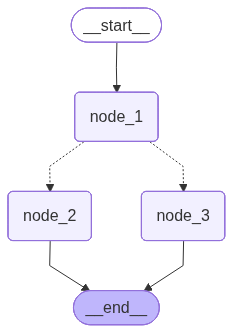

In [30]:
# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [31]:
graph.invoke({"graph_state": "Hi, this is Lance."})

---Node 1---
---Node 2---


{'graph_state': 'Hi, this is Lance. I am happy!'}

In [32]:
import os
from typing import TypedDict, List, Dict, Any, Optional
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage


class EmailState(TypedDict):
    # The email being processed
    email: Dict[str, Any]  # Contains subject, sender, body, etc.

    # Category of the email (inquiry, complaint, etc.)
    email_category: Optional[str]

    # Reason why the email was marked as spam
    spam_reason: Optional[str]

    # Analysis and decisions
    is_spam: Optional[bool]

    # Response generation
    email_draft: Optional[str]

    # Processing metadata
    messages: List[Dict[str, Any]]  # Track conversation with LLM for analysis

In [51]:
# Initialize our LLM
from langchain_ollama import OllamaEmbeddings, ChatOllama

# model = ChatOpenAI(temperature=0)
model = ChatOllama(model="qwen2:7b", temperature=0)


def read_email(state: EmailState):
    """Alfred reads and logs the incoming email"""
    email = state["email"]

    # Here we might do some initial preprocessing
    print(f"Alfred is processing an email from {email['sender']} with subject: {email['subject']}")

    # No state changes needed here
    return {}


def classify_email(state: EmailState):
    """Alfred uses an LLM to determine if the email is spam or legitimate"""
    email = state["email"]

    # Prepare our prompt for the LLM
    prompt = f"""
    As Alfred the butler, analyze this email and determine if it is spam or legitimate.

    Email:
    From: {email['sender']}
    Subject: {email['subject']}
    Body: {email['body']}

    First, determine if this email is spam. If it is spam, explain why.
    If it is legitimate, categorize it (inquiry, complaint, thank you, etc.).

    Strictly follow this format (example): Spam, reason: ...
    or Not spam, reason: ...
    The whole answer will only contain 'spam' or 'not spam'
    """

    # Call the LLM
    messages = [HumanMessage(content=prompt)]
    response = model.invoke(messages)

    # Simple logic to parse the response (in a real app, you'd want more robust parsing)
    response_text = response.content.lower()
    print(response_text)
    is_spam = "spam" in response_text and "not spam" not in response_text

    # Extract a reason if it's spam
    spam_reason = None
    if is_spam and "reason:" in response_text:
        spam_reason = response_text.split("reason:")[1].strip()

    # Determine category if legitimate
    email_category = None
    if not is_spam:
        categories = ["inquiry", "complaint", "thank you", "request", "information"]
        for category in categories:
            if category in response_text:
                email_category = category
                break

    # Update messages for tracking
    new_messages = state.get("messages", []) + [
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": response.content}
    ]

    # Return state updates
    return {
        "is_spam": is_spam,
        "spam_reason": spam_reason,
        "email_category": email_category,
        "messages": new_messages
    }


def handle_spam(state: EmailState):
    """Alfred discards spam email with a note"""
    print(f"Alfred has marked the email as spam. Reason: {state['spam_reason']}")
    print("The email has been moved to the spam folder.")

    # We're done processing this email
    return {}


def draft_response(state: EmailState):
    """Alfred drafts a preliminary response for legitimate emails"""
    email = state["email"]
    category = state["email_category"] or "general"

    # Prepare our prompt for the LLM
    prompt = f"""
    As Alfred the butler, draft a polite preliminary response to this email.

    Email:
    From: {email['sender']}
    Subject: {email['subject']}
    Body: {email['body']}

    This email has been categorized as: {category}

    Draft a brief, professional response that Mr. Hugg can review and personalize before sending.
    """

    # Call the LLM
    messages = [HumanMessage(content=prompt)]
    response = model.invoke(messages)

    # Update messages for tracking
    new_messages = state.get("messages", []) + [
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": response.content}
    ]

    # Return state updates
    return {
        "email_draft": response.content,
        "messages": new_messages
    }


def notify_mr_hugg(state: EmailState):
    """Alfred notifies Mr. Hugg about the email and presents the draft response"""
    email = state["email"]

    print("\n" + "=" * 50)
    print(f"Sir, you've received an email from {email['sender']}.")
    print(f"Subject: {email['subject']}")
    print(f"Category: {state['email_category']}")
    print("\nI've prepared a draft response for your review:")
    print("-" * 50)
    print(state["email_draft"])
    print("=" * 50 + "\n")

    # We're done processing this email
    return {}


def route_email(state: EmailState) -> str:
    """Determine the next step based on spam classification"""
    if state["is_spam"]:
        return "spam"
    else:
        return "legitimate"

In [52]:
# Create the graph
email_graph = StateGraph(EmailState)

# Add nodes
email_graph.add_node("read_email", read_email)
email_graph.add_node("classify_email", classify_email)
email_graph.add_node("handle_spam", handle_spam)
email_graph.add_node("draft_response", draft_response)
email_graph.add_node("notify_mr_hugg", notify_mr_hugg)

# Start the edges
email_graph.add_edge(START, "read_email")
# Add edges - defining the flow
email_graph.add_edge("read_email", "classify_email")

# Add conditional branching from classify_email
email_graph.add_conditional_edges(
    "classify_email",
    route_email,
    {
        "spam": "handle_spam",
        "legitimate": "draft_response"
    }
)

# Add the final edges
email_graph.add_edge("handle_spam", END)
email_graph.add_edge("draft_response", "notify_mr_hugg")
email_graph.add_edge("notify_mr_hugg", END)

# Compile the graph
compiled_graph = email_graph.compile()

In [53]:
# Example legitimate email
legitimate_email = {
    "sender": "john.smith@example.com",
    "subject": "Question about your services",
    "body": "Dear Mr. Hugg, I was referred to you by a colleague and I'm interested in learning more about your consulting services. Could we schedule a call next week? Best regards, John Smith"
}

# Example spam email
spam_email = {
    "sender": "winner@lottery-intl.com",
    "subject": "YOU HAVE WON $5,000,000!!!",
    "body": "CONGRATULATIONS! You have been selected as the winner of our international lottery! To claim your $5,000,000 prize, please send us your bank details and a processing fee of $100."
}

# Process the legitimate email
print("\nProcessing legitimate email...")
legitimate_result = compiled_graph.invoke({
    "email": legitimate_email,
    "is_spam": None,
    "spam_reason": None,
    "email_category": None,
    "email_draft": None,
    "messages": []
})

# Process the spam email
print("\nProcessing spam email...")
spam_result = compiled_graph.invoke({
    "email": spam_email,
    "is_spam": None,
    "spam_reason": None,
    "email_category": None,
    "email_draft": None,
    "messages": []
})


Processing legitimate email...
Alfred is processing an email from john.smith@example.com with subject: Question about your services
not spam, reason: the email is addressed properly, has a clear subject, and requests information about services in a professional manner. there are no signs of promotional content or urgent requests commonly found in spam emails.

Sir, you've received an email from john.smith@example.com.
Subject: Question about your services
Category: request

I've prepared a draft response for your review:
--------------------------------------------------
Subject: Confirmation of Consultation Inquiry - Alfred's Services

Dear Mr. Smith,

Thank you for reaching out to me regarding my consulting services through your colleague’s recommendation. I appreciate the interest shown in my work.

I would be delighted to discuss our potential collaboration further. Would next week suit your schedule? Please let me know a convenient day and time, and we can arrange a call accordin

In [55]:
import os
import dotenv

dotenv.load_dotenv()

True

In [56]:
from langfuse.langchain import CallbackHandler

# Initialize Langfuse CallbackHandler for LangGraph/Langchain (tracing)
langfuse_handler = CallbackHandler()

# Process legitimate email
legitimate_result = compiled_graph.invoke(
    input={"email": legitimate_email, "is_spam": None, "spam_reason": None, "email_category": None,
           "draft_response": None, "messages": []},
    config={"callbacks": [langfuse_handler]}
)

Alfred is processing an email from john.smith@example.com with subject: Question about your services
not spam, reason: the email is addressed properly, has a clear subject, and requests information about services in a professional manner. there are no signs of promotional content or urgent requests commonly found in spam emails.

Sir, you've received an email from john.smith@example.com.
Subject: Question about your services
Category: request

I've prepared a draft response for your review:
--------------------------------------------------
Subject: Confirmation of Consultation Inquiry - Alfred's Services

Dear Mr. Smith,

Thank you for reaching out to me regarding my consulting services through your colleague’s recommendation. I appreciate the interest shown in my work.

I would be delighted to discuss our potential collaboration further. Would next week suit your schedule? Please let me know a convenient day and time, and we can arrange a call accordingly.

In anticipation of our con

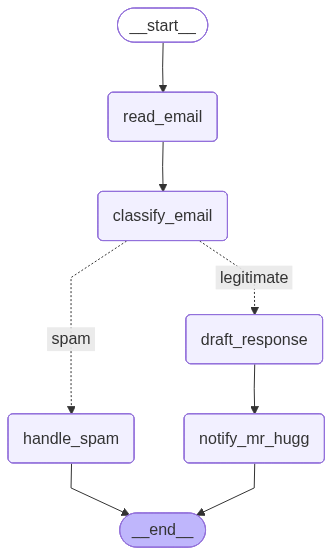

In [58]:
Image(compiled_graph.get_graph().draw_mermaid_png())

In [32]:
import base64
from typing import List, TypedDict, Annotated, Optional
from langchain_openai import ChatOpenAI
from langchain_huggingface import ChatHuggingFace
from langchain_ollama import ChatOllama, OllamaLLM
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage
from langgraph.graph.message import add_messages
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display
import dotenv

dotenv.load_dotenv()


class AgentState(TypedDict):
    # The document provided
    input_file: Optional[str]  # Contains file path (PDF/PNG)
    messages: Annotated[list[AnyMessage], add_messages]

In [67]:
from langchain_huggingface import HuggingFaceEndpoint
from langchain.tools import tool

vision_llm = ChatOpenAI(model="gpt-4o")


# vision_llm = ChatOllama(model="qwen2:7b")
# llm = HuggingFaceEndpoint(
#     repo_id="Qwen/Qwen2.5-VL-7B-Instruct",
#     task="image-text-to-text",  # supports multimodal
# )

# from transformers import AutoProcessor, AutoModelForVision2Seq, pipeline
# from langchain_huggingface import HuggingFacePipeline, ChatHuggingFace
#
# pipe = pipeline(
#     "image-text-to-text",
#     model="Qwen/Qwen2.5-VL-7B-Instruct",
#     device_map="auto"
# )
#
# llm = HuggingFacePipeline(pipeline=pipe)
# vision_llm = ChatHuggingFace(llm=llm)


# vision_llm = ChatOllama(model="gemma3:4b")

@tool
def extract_text(img_path: str) -> str:
    """
    Extract text from an image file using a multimodal model.

    Master Wayne often leaves notes with his training regimen or meal plans.
    This allows me to properly analyze the contents.
    """
    all_text = ""
    try:
        # Read image and encode as base64
        with open(img_path, "rb") as image_file:
            image_bytes = image_file.read()

        image_base64 = base64.b64encode(image_bytes).decode("utf-8")

        # Prepare the prompt including the base64 image data
        message = [
            HumanMessage(
                content=[
                    {
                        "type": "text",
                        "text": (
                            "Extract all the text from this image. "
                            "Return only the extracted text, no explanations."
                        ),
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/png;base64,{image_base64}"
                        },
                    },
                ]
            )
        ]

        # Call the vision-capable model
        response = vision_llm.invoke(message)

        # Append extracted text
        all_text += response.content + "\n\n"

        return all_text.strip()
    except Exception as e:
        # A butler should handle errors gracefully
        error_msg = f"Error extracting text: {str(e)}"
        print(error_msg)
        return ""


def divide(a: int, b: int) -> float:
    """Divide a and b - for Master Wayne's occasional calculations."""
    return a / b


# Equip the butler with tools
tools = [
    divide,
    extract_text
]

llm = vision_llm
# llm_with_tools = llm.bind_tools(tools)
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

In [68]:
def assistant(state: AgentState):
    # System message
    textual_description_of_tool = """
extract_text(img_path: str) -> str:
    Extract text from an image file using a multimodal model.

    Args:
        img_path: A local image file path (strings).

    Returns:
        A single string containing the concatenated text extracted from each image.
divide(a: int, b: int) -> float:
    Divide a and b
"""
    image = state["input_file"]
    sys_msg = SystemMessage(
        content=f"You are a helpful butler named Alfred that serves Mr. Wayne and Batman. You can analyse documents and run computations with provided tools:\n{textual_description_of_tool} \n You have access to some optional images. Currently the loaded image is: {image}")

    return {
        "messages": [llm_with_tools.invoke([sys_msg] + state["messages"])],
        "input_file": state["input_file"]
    }

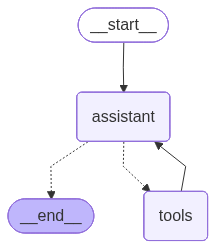

In [35]:
# The graph
builder = StateGraph(AgentState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message requires a tool, route to tools
    # Otherwise, provide a direct response
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show the butler's thought process
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [36]:
messages = [HumanMessage(content="Divide 6790 by 5")]
messages = react_graph.invoke({"messages": messages, "input_file": None})

# Show the messages
for m in messages['messages']:
    m.pretty_print()

RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

In [44]:
from ollama import chat
from ollama import ChatResponse
import requests

# Download the image bytes
url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/bee.jpg"
img_data = requests.get(url).content

# Save it locally (optional)
with open("bee.jpg", "wb") as f:
    f.write(img_data)

# Encode as base64
img_b64 = base64.b64encode(img_data).decode("utf-8")

messages = [
    {
        "role": "system",
        "content": "You are a helpful assistant."
    },
    {
        "role": "user",
        "content": "Describe this image in detail.",
        "images": [img_b64]
    }
]
response: ChatResponse = chat(model='gemma3:4b', messages=messages)
print(response['message']['content'])
# or access fields directly from the response object
print(response.message.content)

Okay, here’s a detailed description of the image:

**Overall Impression:**

The image is a close-up shot of a vibrant pink cosmos flower with a bumblebee on it, set against a lush green background. It’s a bright, cheerful, and somewhat wild-looking photograph.

**Main Subject - The Cosmos Flower:**

*   **Color:** The cosmos is a lovely, saturated shade of pink, leaning towards a blush color.
*   **Shape & Structure:** The flower has a classic cosmos shape – a large, flat, circular face with several pointed petals radiating outwards. The petals are slightly ruffled and have a velvety texture.
*   **Center:** The flower’s center is a golden yellow, filled with pollen.
*   **Number of Flowers:** There are two cosmos flowers visible in the image, one in the foreground and one slightly out of focus in the background.

**The Bumblebee:**

*   **Type:** It’s a bumblebee, with fuzzy black and yellow striped body.
*   **Position:** It’s sitting on the center of the flower, actively collecting 

In [69]:
from langchain_ollama import ChatOllama, OllamaLLM

# llm = ChatOllama(
#     model="gemma3:4b"
# )

llm = ChatOllama(
    model="llama3.1"
)

textual_description_of_tool = """
extract_text(img_path: str) -> str:
    Extract text from an image file using a multimodal model.

    Args:
        img_path: A local image file path (strings).

    Returns:
        A single string containing the concatenated text extracted from each image.
divide(a: int, b: int) -> float:
    Divide a and b
"""
image = "bee.jpg"
sys_msg = SystemMessage(
    content=f"You are a helpful butler named Alfred that serves Mr. Wayne and Batman. You can analyse documents and run computations with provided tools:\n{textual_description_of_tool} \n You have access to some optional images. Currently the loaded image is: {image}")
# llm.invoke()
messages = [HumanMessage(content="can you describe the image")]
# llm.invoke([sys_msg] + messages)
llm_with_tools = llm.bind_tools(tools)

# llm_with_tools.invoke([sys_msg] + messages)
llm_with_tools.invoke([sys_msg] + [HumanMessage(content="divide 100 by 5")])


AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.1', 'created_at': '2025-10-08T07:03:09.431135Z', 'done': True, 'done_reason': 'stop', 'total_duration': 3094662750, 'load_duration': 70769167, 'prompt_eval_count': 368, 'prompt_eval_duration': 2159434417, 'eval_count': 22, 'eval_duration': 861124458, 'model_name': 'llama3.1'}, id='run--9c13021b-3813-48e6-b3fd-6fe1ebf1fe8d-0', tool_calls=[{'name': 'divide', 'args': {'a': 100, 'b': 5}, 'id': '589a1461-8985-4cff-bb70-b69f26dc9933', 'type': 'tool_call'}], usage_metadata={'input_tokens': 368, 'output_tokens': 22, 'total_tokens': 390})

In [15]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_ollama import ChatOllama
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.tools import tool
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages

llm = ChatOllama(model="llama3.2:latest", base_url="http://localhost:11434")


@tool
def internet_search(query: str):
    """
    Search the web for realtime and latest information.
    for examples, news, stock market, weather updates etc.

    Args:
    query: The search query
    """
    search = TavilySearchResults(
        max_results=3,
        search_depth='advanced',
        include_answer=True,
        include_raw_content=True,
    )

    response = search.invoke(query)

    return response


@tool
def llm_search(query: str):
    """
    Use the LLM model for general and basic information.
    """
    response = llm.invoke(query)
    return response


tools = [internet_search, llm_search]
llm_with_tools = llm.bind_tools(tools)


class State(TypedDict):
    # {"messages": ["your message"]}
    messages: Annotated[list, add_messages]


def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}

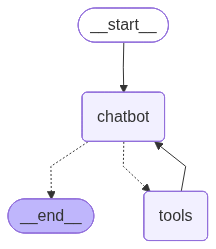

In [10]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from IPython.display import display, Image

memory = MemorySaver()

graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges("chatbot", tools_condition)

graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")

graph = graph_builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
config = {"configurable": {"thread_id": 1}}
output = graph.invoke({"messages": ["Tell me about the earth in 3 points"]}, config=config)

In [16]:
textual_description_of_tool = """
extract_text(img_path: str) -> str:
    Extract text from an image file using a multimodal model.

    Args:
        img_path: A local image file path (strings).

    Returns:
        A single string containing the concatenated text extracted from each image.
divide(a: int, b: int) -> float:
    Divide a and b
"""
image = "bee.jpg"
sys_msg = SystemMessage(
    content=f"")
# llm.invoke()
messages = [HumanMessage(content="can you describe the image")]

llm_with_tools.invoke([sys_msg] + [HumanMessage(content="divide 100 by 5")])

AIMessage(content='{"name": "math_divide", "parameters": {"x": "100", "y": "5"}}', additional_kwargs={}, response_metadata={'model': 'llama3.2:latest', 'created_at': '2025-10-11T05:01:41.553065Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1961339375, 'load_duration': 897962916, 'prompt_eval_count': 233, 'prompt_eval_duration': 626643042, 'eval_count': 24, 'eval_duration': 424846040, 'model_name': 'llama3.2:latest'}, id='run--9711e5a5-eb81-4278-8b11-2a580a346963-0', usage_metadata={'input_tokens': 233, 'output_tokens': 24, 'total_tokens': 257})

In [20]:
from google import genai
import dotenv

dotenv.load_dotenv()
client = genai.Client()

response = client.models.generate_content(
    model="gemini-2.5-flash",
    contents="Explain how AI works in a few words",
)

print(response.text)

AI learns patterns from data to make decisions or predictions.
